In [1]:
import cv2
import os
import pandas as pd
import numpy as np
from PIL import Image
import random
%matplotlib inline

In [2]:
DATA_PATH = '/home/ubuntu/udacity_projects/P3_behavioral_cloning/driving_data/'
SIDE_CAMERA_ADJUSTMENT = .06
SIDE_DRIVING_ADJUSTMENT = .3


In [16]:
def convert_paths(df, folder):
    #convert paths of datalog to those on local computer
    for i in range(len(df)):
        for col in ['img_center', 'img_left', 'img_right']:
            file = df.ix[i, col].split('/')[-1]
            img_path = os.path.join(folder, 'IMG', file)
            df.ix[i, col] = img_path
    return df

def load_datasets(folder_nums):
    #load datasets from multiple folders
    dataframes = []
    for num in folder_nums:
        folder = os.path.join(DATA_PATH, 'track_'+str(num))
        df = pd.read_csv(os.path.join(folder, 'driving_log.csv'))
        df.columns = ['img_center', 'img_left', 'img_right', 'steering', 'throttle', 'break', 'speed']
        df = convert_paths(df, folder)
        dataframes.append(df)
    df = pd.concat(dataframes)
    return df
df_center = load_datasets([11,14])

df_left = load_datasets([13,15])
df_right = load_datasets([12,16])
df_left['steering'] = df_left['steering'] + SIDE_DRIVING_ADJUSTMENT
df_right['steering'] = df_right['steering'] - SIDE_DRIVING_ADJUSTMENT
df = pd.concat([df_center, df_left, df_right])


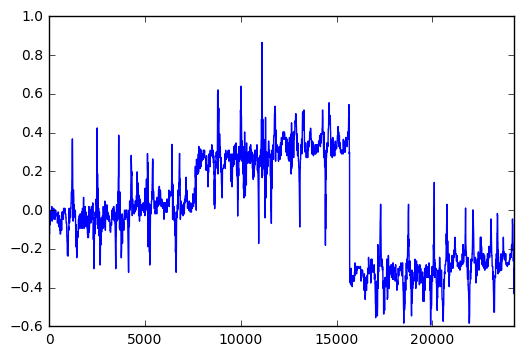

In [17]:
df = df.reset_index(drop=True)
df['steering'].plot()

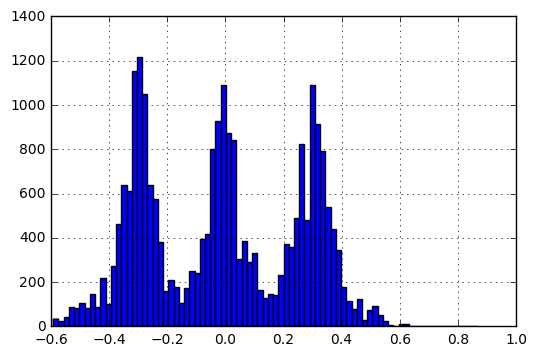

In [18]:
df['steering'].hist(bins=81)

In [19]:
#ix = df[(df['steering'] > -.01) & (df['steering'] < .01) ].index

In [20]:
#arr = list(ix.get_values())
#ix_remove = random.sample(arr, round(len(arr) * .5))
#ix_remove = df.index.isin(ix_remove)
#df_curves = df[~ix_remove]
#len(df_curves)

In [21]:
#df_curves['steering'].hist(bins=81)

In [22]:
def get_data(df, row, img_col, 
             steering_col='steering'):
    img_path = df[img_col][row]
    #print(img_path)
    img = Image.open(img_path)
    img_arr = np.array(img)
    raw_angle = df[steering_col][row]
    #print('raw_angle ', raw_angle)
    angle = raw_angle + steering_adjust
    #print('adjusted angle', angle)
    return img_arr, angle

In [23]:
def data_gen(df, batch_size=64, sample_ix=None):
    arg_choices = [
                    {'img_col': 'img_center', 'adjust': 0.0},
                    {'img_col': 'img_left',   'adjust': SIDE_CAMERA_ADJUSTMENT},
                    {'img_col': 'img_right',  'adjust': -SIDE_CAMERA_ADJUSTMENT},]
       
    if sample_ix is None:
        sample_ix = list(range(len(df)))
        random.shuffle(sample_ix)
    
    #print(df.head())
    while True:
        images=[]
        angles=[]
        rows = sample_ix[:batch_size]
        for i in rows:
            args = random.choice(arg_choices)
            img, angle = get_data(df, i, args['img_col'], steering_adjust=args['adjust'])

            
            flip = random.randint(0, 1)
            if flip == 1:
                img = np.fliplr(img)
                angle = -angle
                
            images.append(img)
            angles.append(angle)

        X_train = np.array(images)
        y_train = np.array(angles)
        yield X_train, y_train

In [24]:
df = df.reset_index(drop=True)
n = len(df)
sample_ix = list(range(n))
random.shuffle(sample_ix)

#separate index into train and validation
train_n = round(n * .8)
train_ix = sample_ix[:train_n]
val_ix = sample_ix[train_n:]

#create data generators with those indexes
train_gen = data_gen(df, sample_ix=train_ix)
val_gen = data_gen(df, sample_ix=val_ix)


In [25]:
import keras
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, AveragePooling2D, MaxPool2D, SimpleRNN, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Cropping2D, Lambda
from keras.regularizers import l2


def build_model1():
    '''
    Function to create models with convolutional heads and dense tails.
    Accepts dictionaries defining the conv and dense layers.
    '''

    img_in = Input(shape=(160, 320,3), name='img_in')
    x = Lambda(lambda x: (x / 255.0) - 0.5)(img_in)
    x = Cropping2D(cropping=((60, 20), (0, 0)))(x)
    #x = AveragePooling2D(2,2)(x)
    x = Convolution2D(16, (4,4), strides=(3,4), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(32, (4,4), strides=(1,2), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(48, (4,4), strides=(1,2), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Convolution2D(64, (3,3), activation='elu', kernel_regularizer=l2(0.001))(x)
    x = Flatten(name='flattened')(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.002))(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.002))(x)
    x = Dense(10, activation='relu', kernel_regularizer=l2(0.002))(x)
    angle = Dense(1)(x)
    
    model = Model(inputs=[img_in], outputs=[angle])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

def build_model2():
    '''
    Function to create models with convolutional heads and dense tails.
    Accepts dictionaries defining the conv and dense layers.
    '''

    img_in = Input(shape=(160, 320,3), name='img_in')
    x = Lambda(lambda x: (x / 255.0) - 0.5)(img_in)
    x = Cropping2D(cropping=((60, 20), (0, 0)))(x)
    #x = AveragePooling2D(2,2)(x)
    x = Convolution2D(3, (1,1), activation='elu')(x)
    x = Convolution2D(32, (4,4), strides=(1,2), activation='elu')(x)
    x = Convolution2D(32, (3,3), strides=(1,2), activation='elu')(x)
    x = MaxPool2D(2,2)(x)
    x = Dropout(.5)(x)
    x = Convolution2D(64, (3,3), activation='elu')(x)
    x = Convolution2D(64, (3,3), activation='elu')(x)
    x = MaxPool2D(2,2)(x)
    x = Dropout(.5)(x)
    x = Convolution2D(128, (3,3), activation='elu')(x)
    x = Convolution2D(128, (3,3), activation='elu')(x)
    x = MaxPool2D(2,2)(x)
    x = Dropout(.5)(x)
    
    x = Flatten(name='flattened')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.2)(x)
    x = Dense(10, activation='relu')(x)
    angle = Dense(1)(x)
    
    model = Model(inputs=[img_in], outputs=[angle])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

In [26]:
model = build_model1()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 160, 320, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 80, 16)        784       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 39, 32)        8224      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 18, 48)        24624     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 16, 64)        27712     
__________

In [27]:
#checkpoint to save model after each epoch
save_best = keras.callbacks.ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, 
                                      save_best_only=True, mode='min')

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.0005, patience=2, 
                                     verbose=1, mode='auto')

callbacks_list = [save_best, early_stop]

In [28]:
model.fit_generator(train_gen, 100, epochs=50, validation_data=val_gen, 
                    callbacks=callbacks_list, validation_steps=40)
    

Epoch 1/50
100/100 [==============================] - 51s - loss: 0.4920 - val_loss: 0.3729
Epoch 2/50
100/100 [==============================] - 16s - loss: 0.2487 - val_loss: 0.2646
Epoch 3/50
100/100 [==============================] - 16s - loss: 0.1673 - val_loss: 0.1999
Epoch 4/50
100/100 [==============================] - 16s - loss: 0.1248 - val_loss: 0.1682
Epoch 5/50
100/100 [==============================] - 16s - loss: 0.0977 - val_loss: 0.1472
Epoch 6/50
100/100 [==============================] - 16s - loss: 0.0818 - val_loss: 0.1338
Epoch 7/50
100/100 [==============================] - 16s - loss: 0.0677 - val_loss: 0.1264
Epoch 8/50
100/100 [==============================] - 16s - loss: 0.0616 - val_loss: 0.1187
Epoch 9/50
100/100 [==============================] - 16s - loss: 0.0550 - val_loss: 0.1183
Epoch 10/50
100/100 [==============================] - 16s - loss: 0.0495 - val_loss: 0.1099
Epoch 11/50
100/100 [==============================] - 16s - loss: 0.0462 - val